# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [15]:
# import libraries
import pandas as pd;
from sqlalchemy import create_engine;
import re;
from nltk import word_tokenize, pos_tag;
from nltk.corpus import stopwords;
from nltk.stem.wordnet import WordNetLemmatizer;
from sklearn.pipeline import Pipeline;
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.ensemble import RandomForestClassifier;
from sklearn.multioutput import MultiOutputClassifier;
from sklearn.cross_validation import train_test_split;
import seaborn as sns;
import numpy as np;

In [2]:
import nltk;
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# load data from database
engine = create_engine('sqlite:///figure_eight.db')
conn = engine.connect();
df = pd.read_sql('select * from disaster_data_cleaned', conn)
X = df['message']
Y = df.select_dtypes('int64').drop('id', axis=1)

In [4]:
print('X shape :', X.shape)
print('Y shape :', Y.shape)

X shape : (26216,)
Y shape : (26216, 36)


### 2. Write a tokenization function to process your text data

In [5]:
word_net = WordNetLemmatizer();

In [6]:
def tokenize(text):
    # lower case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower());
    words = word_tokenize(text);
    words = [word for word in words if word not in stopwords.words('english')];
    lemmed = [word_net.lemmatize(word) for word in words];
    return lemmed;

In [7]:
tokenize('when the sun rises in the west and sets in the east, when the seas go dry and the mountains blow in the winds like leaves')

['sun',
 'rise',
 'west',
 'set',
 'east',
 'sea',
 'go',
 'dry',
 'mountain',
 'blow',
 'wind',
 'like',
 'leaf']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [8]:
forest = RandomForestClassifier(n_estimators=10, random_state=1024);
pipeline = Pipeline([('count', CountVectorizer(tokenizer=tokenize)),
                     ('tfidf', TfidfTransformer()),
                     ('model', MultiOutputClassifier(estimator=forest, n_jobs=1))
                    ]);

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=1024);

In [10]:
pipeline.fit(X_train, Y_train);

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [11]:
Y_preds = pipeline.predict(X_test);
Y_preds = pd.DataFrame(Y_preds);
Y_preds.columns = Y_test.columns;
Y_preds.index = Y_test.index;

In [12]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix;
#print('acc ', accuracy_score(Y_test, Y_preds));
#print('f1s', f1_score(Y_test, Y_preds))

#classification_report(Y_test, Y_preds)
for column in Y_test.columns:
    print('Column : ' , column)
    print(classification_report(Y_test[column], Y_preds[column]))

Column :  related
             precision    recall  f1-score   support

          0       0.62      0.47      0.53      2005
          1       0.85      0.91      0.88      6585
          2       0.40      0.37      0.38        62

avg / total       0.79      0.80      0.79      8652

Column :  request
             precision    recall  f1-score   support

          0       0.89      0.98      0.93      7154
          1       0.80      0.44      0.57      1498

avg / total       0.88      0.88      0.87      8652

Column :  offer
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8615
          1       0.00      0.00      0.00        37

avg / total       0.99      1.00      0.99      8652

Column :  aid_related
             precision    recall  f1-score   support

          0       0.76      0.85      0.80      5056
          1       0.74      0.61      0.67      3596

avg / total       0.75      0.75      0.75      8652

Column :  med

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
cross_dict = [];
cross_cols = [];
for column_a in Y_test.columns:
    cross_cols.append(column_a);
    col_dict = {};
    for column_b in Y_preds.columns:
        #print(column_a, column_b, (foo[column_a] == bar[column_b]).sum())
        col_dict[column_b] = (Y_test[column_a] == Y_preds[column_b]).sum()
    
    cross_dict.append(col_dict)
    
cross_dict = pd.DataFrame(cross_dict);
cross_dict.index = cross_cols;

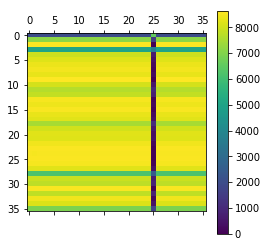

In [53]:
import matplotlib.pyplot as plt;
import numpy as np;
plt.matshow(cross_dict)

plt.colorbar()

Avg of f1 scores:  0.944338495916


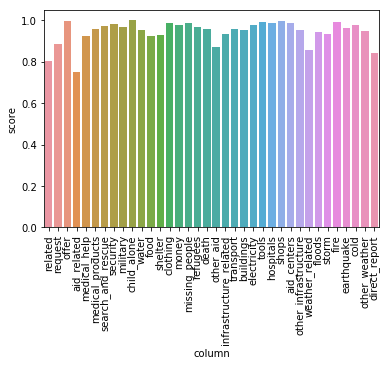

In [16]:
score_dict = [];
for column in Y_test.columns:
    score = f1_score(Y_test[column], Y_preds[column], average='micro');
    score_dict.append({'column' : column, 'score' : score});

score_df = pd.DataFrame(score_dict);

g = sns.barplot(score_df['column'], score_df['score']);
for item in g.get_xticklabels():
    item.set_rotation(90)
    
print('Avg of f1 scores: ', np.mean([val for x,val in score_df.values]))

### 6. Improve your model
Use grid search to find better parameters. 

In [17]:
from sklearn.model_selection import GridSearchCV;

forest = RandomForestClassifier(n_estimators=10, random_state=1024);
pipeline = Pipeline([('count', CountVectorizer(tokenizer=tokenize)),
                     ('tfidf', TfidfTransformer()),
                     ('model', MultiOutputClassifier(estimator=forest, n_jobs=1))
                    ]);

parameters = {'model__estimator__max_depth' : [5, 10], 'model__estimator__max_features' : [5, 10], 'model__estimator__criterion' : ['gini', 'entropy']};

cv = GridSearchCV(pipeline, param_grid=parameters, verbose=2);

In [18]:
cv.fit(X_train, Y_train);

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] model__estimator__criterion=gini, model__estimator__max_depth=5, model__estimator__max_features=5 
[CV]  model__estimator__criterion=gini, model__estimator__max_depth=5, model__estimator__max_features=5, total= 1.3min
[CV] model__estimator__criterion=gini, model__estimator__max_depth=5, model__estimator__max_features=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV]  model__estimator__criterion=gini, model__estimator__max_depth=5, model__estimator__max_features=5, total= 1.3min
[CV] model__estimator__criterion=gini, model__estimator__max_depth=5, model__estimator__max_features=5 
[CV]  model__estimator__criterion=gini, model__estimator__max_depth=5, model__estimator__max_features=5, total= 1.3min
[CV] model__estimator__criterion=gini, model__estimator__max_depth=5, model__estimator__max_features=10 
[CV]  model__estimator__criterion=gini, model__estimator__max_depth=5, model__estimator__max_features=10, total= 1.3min
[CV] model__estimator__criterion=gini, model__estimator__max_depth=5, model__estimator__max_features=10 
[CV]  model__estimator__criterion=gini, model__estimator__max_depth=5, model__estimator__max_features=10, total= 1.3min
[CV] model__estimator__criterion=gini, model__estimator__max_depth=5, model__estimator__max_features=10 
[CV]  model__estimator__criterion=gini, model__estimator__max_depth=5, model__estimator__max_features=1

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 51.5min finished


In [21]:
cv.best_params_

{'model__estimator__criterion': 'gini',
 'model__estimator__max_depth': 5,
 'model__estimator__max_features': 5}

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [17]:
forest = RandomForestClassifier(n_estimators=10, random_state=1024, criterion='gini', max_depth=5, max_features=5);
pipeline = Pipeline([('count', CountVectorizer(tokenizer=tokenize)),
                     ('tfidf', TfidfTransformer()),
                     ('model', MultiOutputClassifier(estimator=forest, n_jobs=1))
                    ]);

pipeline.fit(X_train, Y_train);

Y_preds = pipeline.predict(X_test);

In [18]:
Y_preds = pd.DataFrame(Y_preds);
Y_preds.columns = Y_test.columns;
Y_preds.index = Y_test.index;

for column in Y_test.columns:
    print('Column : ' , column)
    print(classification_report(Y_test[column], Y_preds[column]))

Column :  related
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      2005
          1       0.76      1.00      0.86      6585
          2       0.00      0.00      0.00        62

avg / total       0.58      0.76      0.66      8652

Column :  request
             precision    recall  f1-score   support

          0       0.83      1.00      0.91      7154
          1       0.00      0.00      0.00      1498

avg / total       0.68      0.83      0.75      8652

Column :  offer
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8615
          1       0.00      0.00      0.00        37

avg / total       0.99      1.00      0.99      8652

Column :  aid_related
             precision    recall  f1-score   support

          0       0.58      1.00      0.74      5056
          1       1.00      0.00      0.00      3596

avg / total       0.76      0.58      0.43      8652

Column :  med

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Avg of f1 scores:  0.926124980737


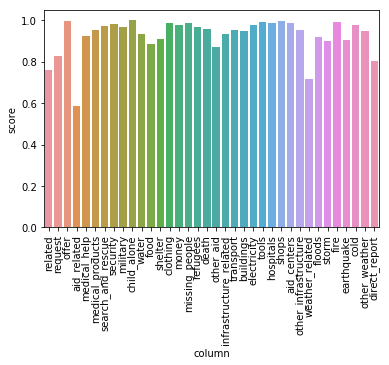

In [20]:
score_dict = [];
for column in Y_test.columns:
    score = f1_score(Y_test[column], Y_preds[column], average='micro');
    score_dict.append({'column' : column, 'score' : score});

score_df = pd.DataFrame(score_dict);

g = sns.barplot(score_df['column'], score_df['score']);
for item in g.get_xticklabels():
    item.set_rotation(90)
    
print('Avg of f1 scores: ', np.mean([val for x,val in score_df.values]))

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [27]:
forest = RandomForestClassifier(n_estimators=30, random_state=1024, criterion='gini', max_depth=5, max_features=5);

pipeline = Pipeline([('count', CountVectorizer(tokenizer=tokenize)),
                     ('tfidf', TfidfTransformer()),
                     ('model', MultiOutputClassifier(estimator=forest, n_jobs=1))
                    ]);

pipeline.fit(X_train, Y_train);

Y_preds = pipeline.predict(X_test);

Avg of f1 scores:  0.926115349052


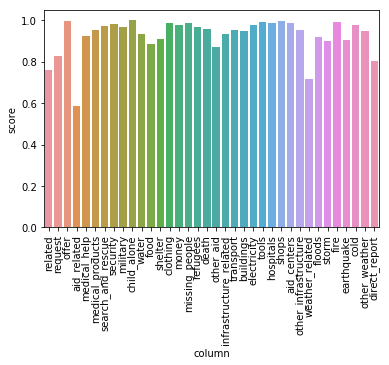

In [29]:
Y_preds = pd.DataFrame(Y_preds);
Y_preds.columns = Y_test.columns;
Y_preds.index = Y_test.index;

score_dict = [];
for column in Y_test.columns:
    score = f1_score(Y_test[column], Y_preds[column], average='micro');
    score_dict.append({'column' : column, 'score' : score});

score_df = pd.DataFrame(score_dict);

g = sns.barplot(score_df['column'], score_df['score']);
for item in g.get_xticklabels():
    item.set_rotation(90)
    
print('Avg of f1 scores: ', np.mean([val for x,val in score_df.values]))

### 9. Export your model as a pickle file

In [35]:
import pickle;

pickle.dump(forest, open('forest.pkl', 'wb'));
pickle.dump(pipeline, open('pipeline.pkl', 'wb'));

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.